In [84]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import warnings
import matplotlib.pyplot as plt
import seaborn as sn
warnings.filterwarnings('ignore')

In [85]:
features = pd.read_csv('spx_cons_norm.csv')
#features = features[['tic','datadate','forward_excess_ret','multi_class','ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda']]
features = features[['tic','datadate','forward_excess_ret','ROE','Asset Turnover','MA12','Size','PB','ev_ebitda']]
features = features.dropna(subset=['forward_excess_ret'])
features_after = features.groupby(['tic']).ffill()
features_after = pd.merge(features_after,features[['tic']],how='left',left_index=True,right_index=True)
#features_after['multi_class']=pd.qcut(features_after['forward_excess_ret'], 10,labels=False)
cols = [col for col in features_after.columns if col not in ['datadate','forward_excess_ret','tic']]
df_na = features_after.isnull()

df_mean = features_after.groupby('tic').mean()

for col in cols:
    na_series = features_after[col].isnull()
    names = list(features_after.loc[na_series,'tic'])     

    t = df_mean.loc[names,col]
    t.index = features_after.loc[na_series,col].index

    
    features_after.loc[na_series,col] = t

for col in cols:
    na_series = features_after[col].isnull()
    mean = np.mean(features_after[col]) 
    features_after.loc[na_series,col] = mean

In [98]:
boundraies = pd.qcut(features_after['forward_excess_ret'],10)
boundraies_unique=np.unique(boundraies)

In [113]:
(-0.3) in boundraies_unique[0]

True

In [91]:
pd.qcut(features_after['forward_excess_ret'],10)

0        (-0.0253, -0.0106]
1        (-0.0106, 0.00205]
2           (0.029, 0.0464]
3        (-0.0436, -0.0253]
4         (-0.483, -0.0732]
                ...        
58185    (-0.0106, 0.00205]
58186       (0.029, 0.0464]
58187    (-0.0106, 0.00205]
58188    (-0.0106, 0.00205]
58189      (0.00205, 0.015]
Name: forward_excess_ret, Length: 58190, dtype: category
Categories (10, interval[float64]): [(-0.483, -0.0732] < (-0.0732, -0.0436] < (-0.0436, -0.0253] < (-0.0253, -0.0106] ... (0.015, 0.029] < (0.029, 0.0464] < (0.0464, 0.0751] < (0.0751, 0.742]]

In [92]:
pd.qcut(features_after['forward_excess_ret'],10,labels=False)

0        3
1        4
2        7
3        2
4        0
        ..
58185    4
58186    7
58187    4
58188    4
58189    5
Name: forward_excess_ret, Length: 58190, dtype: int64

In [99]:
features_after['multi_class']=pd.qcut(features_after['forward_excess_ret'], 10,labels=False)
X = features_after[['ROE','Asset Turnover','MA12','Size','PB','ev_ebitda']]
#X = sm.add_constant(X)
Y = features_after[['multi_class','forward_excess_ret']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=52)

In [100]:
X_test=X_test.reset_index()
X_test=X_test.drop(['index'],axis=1)
y_test=y_test.reset_index()

In [108]:
y_test['new_class']=pd.qcut(y_test['forward_excess_ret'], 10,labels=False)#decile only in y_test
print(y_test.groupby('multi_class').count())
print(y_test.groupby('new_class').count())

             index  forward_excess_ret  new_class
multi_class                                      
0             1746                1746       1746
1             1793                1793       1793
2             1769                1769       1769
3             1733                1733       1733
4             1680                1680       1680
5             1726                1726       1726
6             1795                1795       1795
7             1749                1749       1749
8             1733                1733       1733
9             1733                1733       1733
           index  multi_class  forward_excess_ret
new_class                                        
0           1746         1746                1746
1           1746         1746                1746
2           1745         1745                1745
3           1746         1746                1746
4           1746         1746                1746
5           1745         1745                1745


In [109]:
#y_test['new_class'][0]=1
y_test['new_class'][0]

7

In [181]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

def print_metrics(confusion_matrix):
    print("label precision recall")
    for label in range(10):
        print(f"{label:5d} {precision(label, confusion_matrix):9.3f} {recall(label, confusion_matrix):6.3f}")
    print("precision total:", precision_macro_average(confusion_matrix))
    print("recall total:", recall_macro_average(confusion_matrix))
    print("accuracy total:",accuracy(confusion_matrix))

In [188]:
def self_class(predict):
    #classify to decile in predictions
    prediction = pd.DataFrame(columns=['return','multi_class'])
    prediction['return']=predict
    prediction['multi_class']=pd.qcut(prediction['return'], 10, labels=False,duplicates="drop") 
    #prediction['multi_class']
    return prediction

def original_class(predict):
    #classify based on original data class disctribution
    prediction = pd.DataFrame(columns=['return','multi_class'])
    prediction['return']=predict
    for i in range(len(prediction['return'])):
        for index, bound in enumerate(boundraies_unique):
            if prediction['return'][i] in bound:
                prediction['multi_class'][i] = index
    return prediction

def confusion_matrix(true,prediction):
    cm = pd.DataFrame(columns = [0,1,2,3,4,5,6,7,8,9],index = [0,1,2,3,4,5,6,7,8,9])
    cm = cm.replace(np.nan,0)
    for i in range(len(y_test)):
        #logistic_df.loc[y_test['new_class'][i],prediction['multi_class'][i]] += 1
        cm.loc[true[i],prediction[i]] += 1 #index is true value, column is prediction
    return cm

In [189]:
def metrics(predict,classification_model,true_value):
    #classification_model could be "self" or "original"
    #true_value could be y_test['multi_class'] or y_test['new_class']
    if classification_model=="self":
        prediction = self_class(predict)
    elif classification_model=="original":
        prediction = original_class(predict)
    else:
        print("Wrong classification_model")
        return
    print("Prediction class distribution:")
    print(prediction.groupby('multi_class').count()) # check if biased
          
    cm = confusion_matrix(true_value,prediction['multi_class'])
    print(" ")
    print("Confusion matrix is: (index is true value, column is prediction)")
    print(cm)
    plt.figure(figsize = (10,7))
    sn.heatmap(cm, annot=True, cmap="Blues")
    cm_np=cm.values
    print(" ")
    print_metrics(cm_np)
    return

# Lasso

In [147]:
#Linear
reg = LassoCV(cv=5,fit_intercept=False,alphas=np.linspace(0.00001,0.001,100)).fit(X_train,y_train_ret)   
#print(reg.alphas_)
print(reg.coef_)
linear_predict=reg.predict(X_test)
linear_predict

[ 0.          0.00048183  0.00017922 -0.00030268 -0.          0.00035648]


array([-4.85938926e-04,  3.20395822e-04, -1.41440192e-04, ...,
        6.31632172e-05, -1.01227029e-03, -6.85508126e-05])

In [167]:
linear_predict

array([-4.85938926e-04,  3.20395822e-04, -1.41440192e-04, ...,
        6.31632172e-05, -1.01227029e-03, -6.85508126e-05])

Prediction class distribution:
             return
multi_class        
0              1746
1              1746
2              1745
3              1746
4              1746
5              1745
6              1746
7              1745
8              1746
9              1746
 
Confusion matrix is: (index is true value, column is prediction)
     0    1    2    3    4    5    6    7    8    9
0  164  182  167  183  161  168  159  164  201  197
1  166  165  174  169  168  148  189  184  188  195
2  192  183  179  178  170  175  179  165  150  174
3  188  182  175  183  176  162  186  176  150  168
4  180  195  193  156  175  182  176  190  159  140
5  173  191  176  178  169  177  173  155  186  167
6  205  181  170  182  155  176  171  190  159  157
7  157  169  169  179  193  186  177  182  175  158
8  163  155  168  163  200  204  167  173  169  184
9  158  143  174  175  179  167  169  166  209  206
 
label precision recall
    0     0.094  0.094
    1     0.095  0.095
    2     0.103  0.

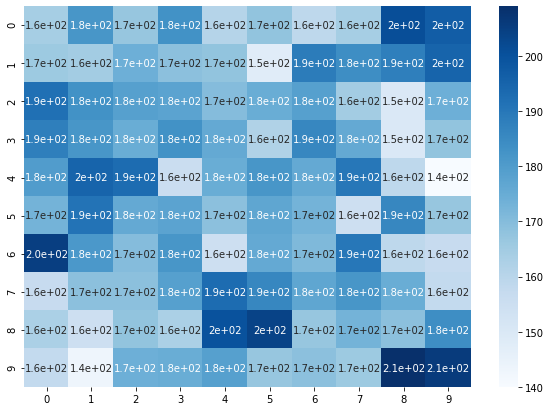

In [182]:
metrics(linear_predict,"self",y_test['new_class'])

Prediction class distribution:
             return
multi_class        
4             17387
5                70
 
Confusion matrix is: (index is true value, column is prediction)
   0  1  2  3     4   5  6  7  8  9
0  0  0  0  0  1740   6  0  0  0  0
1  0  0  0  0  1737   9  0  0  0  0
2  0  0  0  0  1735  10  0  0  0  0
3  0  0  0  0  1743   3  0  0  0  0
4  0  0  0  0  1741   5  0  0  0  0
5  0  0  0  0  1736   9  0  0  0  0
6  0  0  0  0  1740   6  0  0  0  0
7  0  0  0  0  1739   6  0  0  0  0
8  0  0  0  0  1740   6  0  0  0  0
9  0  0  0  0  1736  10  0  0  0  0
 
label precision recall
    0       nan  0.000
    1       nan  0.000
    2       nan  0.000
    3       nan  0.000
    4     0.100  0.997
    5     0.129  0.005
    6       nan  0.000
    7       nan  0.000
    8       nan  0.000
    9       nan  0.000
precision total: nan
recall total: 0.10022939046925103
accuracy total: 0.10024631952798305


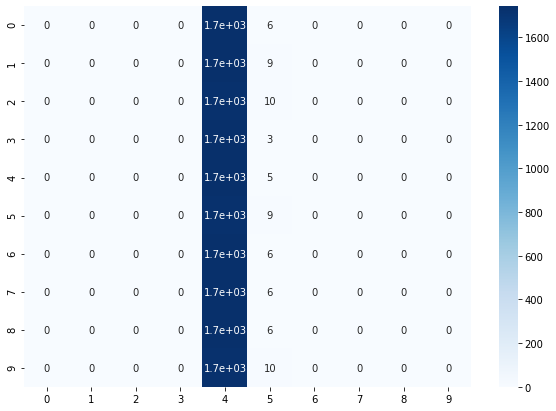

In [183]:
metrics(linear_predict,"original",y_test['new_class'])

Prediction class distribution:
             return
multi_class        
0              1746
1              1746
2              1745
3              1746
4              1746
5              1745
6              1746
7              1745
8              1746
9              1746
 
Confusion matrix is: (index is true value, column is prediction)
     0    1    2    3    4    5    6    7    8    9
0  164  182  167  183  161  168  159  164  201  197
1  173  169  176  175  174  154  191  189  191  201
2  193  186  184  176  170  173  187  164  152  184
3  182  184  173  184  175  164  184  177  153  157
4  178  185  185  150  170  176  167  185  150  134
5  169  191  177  177  165  172  174  153  184  164
6  210  184  175  185  161  184  173  195  164  164
7  158  169  168  180  194  186  179  184  175  156
8  162  155  168  163  197  205  165  168  167  183
9  157  141  172  173  179  163  167  166  209  206
 
label precision recall
    0     0.094  0.094
    1     0.097  0.094
    2     0.105  0.

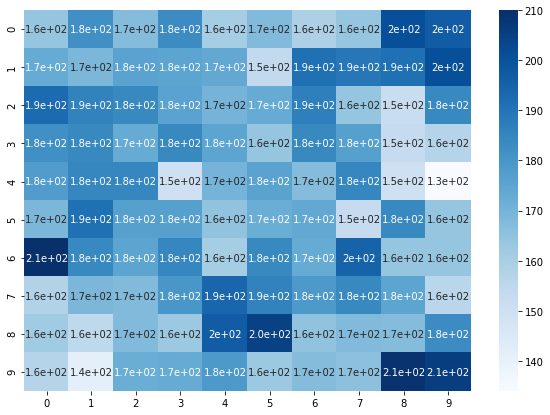

In [184]:
metrics(linear_predict,"self",y_test['multi_class'])

# KNN

In [16]:
#KNN
for n in [2,3,4,5,6,7,8]:
    neigh = KNeighborsRegressor(n_neighbors=n)
    #neigh.fit(X_train,y_train)
    scores = cross_val_score(neigh, X_train,y_train_ret, cv=5)
    print(n,np.mean(scores))

2 -0.5010384204757524
3 -0.33243379791066985
4 -0.2514948538341467
5 -0.1999391095261529
6 -0.1629049773254724
7 -0.137542936655489
8 -0.12355743937633394


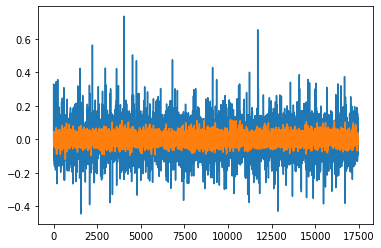

In [164]:
neigh = KNeighborsRegressor(n_neighbors=8)
knn_predict = neigh.fit(X_train,y_train_ret).predict(X_test)
plt.plot(range(17457),y_test['forward_excess_ret'])
plt.plot(range(17457),knn_predict)

In [168]:
knn_predict
knn_predict_1d=knn_predict[:,0]

In [169]:
knn_predict_1d

array([ 0.00553439,  0.01523006, -0.00337255, ...,  0.0350842 ,
        0.01811972,  0.01824043])

Prediction class distribution:
             return
multi_class        
0              1746
1              1746
2              1745
3              1746
4              1746
5              1745
6              1746
7              1745
8              1746
9              1746
 
Confusion matrix is: (index is true value, column is prediction)
     0    1    2    3    4    5    6    7    8    9
0  214  173  164  181  158  158  172  148  152  226
1  192  175  162  159  183  150  167  182  198  225
2  184  189  174  181  186  182  173  188  157  155
3  157  174  180  182  164  183  189  164  177  163
4  144  162  178  174  178  182  173  167  184  138
5  159  158  190  176  184  182  177  177  160  163
6  153  192  195  176  190  191  190  189  169  150
7  161  185  179  164  185  188  174  169  186  158
8  161  168  165  190  170  173  177  175  188  166
9  221  170  158  163  148  156  154  186  175  202
 
label precision recall
    0     0.123  0.123
    1     0.100  0.098
    2     0.100  0.

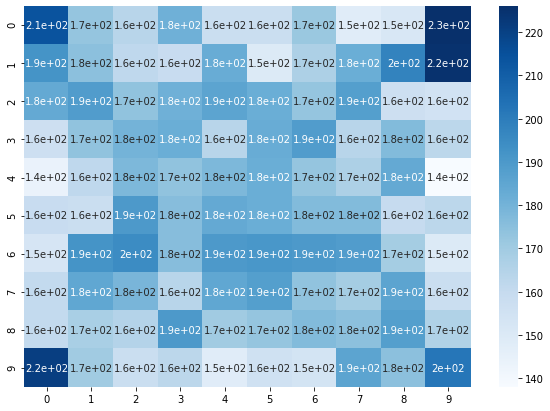

In [185]:
metrics(knn_predict_1d,"self",y_test['multi_class'])

Prediction class distribution:
             return
multi_class        
0              1746
1              1746
2              1745
3              1746
4              1746
5              1745
6              1746
7              1745
8              1746
9              1746
 
Confusion matrix is: (index is true value, column is prediction)
     0    1    2    3    4    5    6    7    8    9
0  214  173  164  181  158  158  172  148  152  226
1  188  172  158  153  180  144  166  175  194  216
2  183  182  172  180  183  179  164  190  155  157
3  157  175  175  184  167  186  195  166  175  166
4  150  171  190  179  183  190  177  171  192  143
5  161  158  192  179  184  184  178  180  164  165
6  147  186  190  171  185  185  188  185  162  147
7  163  190  178  166  181  186  173  168  187  153
8  161  167  167  189  177  175  178  175  189  168
9  222  172  159  164  148  158  155  187  176  205
 
label precision recall
    0     0.123  0.123
    1     0.099  0.099
    2     0.099  0.

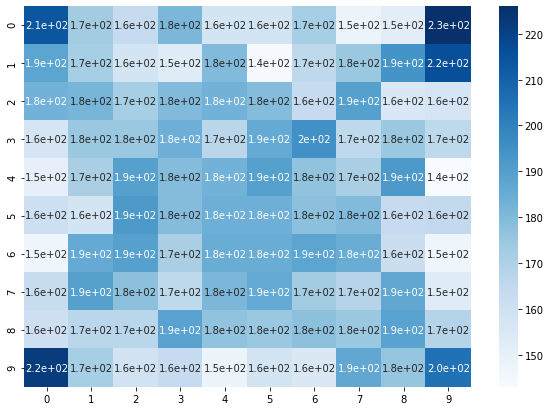

In [186]:
metrics(knn_predict_1d,"self",y_test['new_class'])

# Random Forest

In [6]:
#random forest
for max_depth in [2,3,4,5,6,7]:
    regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
    scores = cross_val_score(regr, X_train,y_train_ret, cv=5)
    print(max_depth,np.mean(scores))

2 -0.0008640087858114099
3 -0.001115361124667902
4 -0.001513577498287466
5 -0.0017461525406849755
6 -0.0026166156564013665
7 -0.0034032223932203287


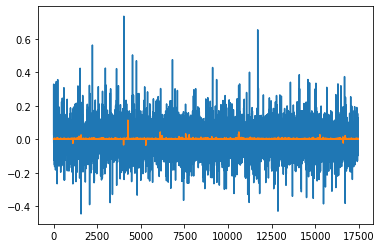

In [174]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
fm_predict = regr.fit(X_train,y_train_ret).predict(X_test)
plt.plot(range(17457),y_test['forward_excess_ret'])
plt.plot(range(17457),fm_predict)

In [175]:
fm_predict

array([0.00149605, 0.00206356, 0.00202523, ..., 0.00206356, 0.00671394,
       0.00198978])

Prediction class distribution:
             return
multi_class        
2                 2
3                 2
4              7804
5              9636
6                 8
7                 4
9                 1
 
Confusion matrix is: (index is true value, column is prediction)
   0  1  2  3    4     5  6  7  8  9
0  0  0  0  1  846   895  2  1  0  1
1  0  0  0  0  785   957  2  2  0  0
2  0  0  0  0  784   961  0  0  0  0
3  0  0  2  0  774   969  1  0  0  0
4  0  0  0  0  779   966  1  0  0  0
5  0  0  0  0  751   993  1  0  0  0
6  0  0  0  0  764   981  1  0  0  0
7  0  0  0  0  775   970  0  0  0  0
8  0  0  0  0  731  1015  0  0  0  0
9  0  0  0  1  815   929  0  1  0  0
 
label precision recall
    0       nan  0.000
    1       nan  0.000
    2     0.000  0.000
    3     0.000  0.000
    4     0.100  0.446
    5     0.103  0.569
    6     0.125  0.001
    7     0.000  0.000
    8       nan  0.000
    9     0.000  0.000
precision total: nan
recall total: 0.10157898364497484
accur

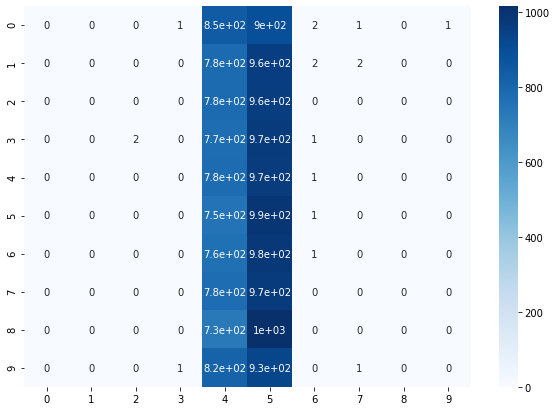

In [187]:
metrics(fm_predict,"original",y_test['new_class'])

Prediction class distribution:
             return
multi_class        
0              1758
1              1758
2              1766
3              2356
4              5142
5              1206
6              1874
7              1597
 
Confusion matrix is: (index is true value, column is prediction)
     0    1    2    3    4    5    6    7  8  9
0  239  194  187  199  428  139  192  168  0  0
1  200  191  167  209  496  117  206  160  0  0
2  163  180  180  242  512  126  189  153  0  0
3  156  169  173  260  549  115  185  139  0  0
4  143  177  181  267  545  113  176  144  0  0
5  132  165  185  255  567   93  187  161  0  0
6  164  161  170  260  530  139  181  141  0  0
7  169  178  165  250  549  115  179  140  0  0
8  165  166  174  211  550  124  172  184  0  0
9  227  177  184  203  416  125  207  207  0  0
 
label precision recall
    0     0.136  0.137
    1     0.109  0.109
    2     0.102  0.103
    3     0.110  0.149
    4     0.106  0.312
    5     0.077  0.053
    6     0

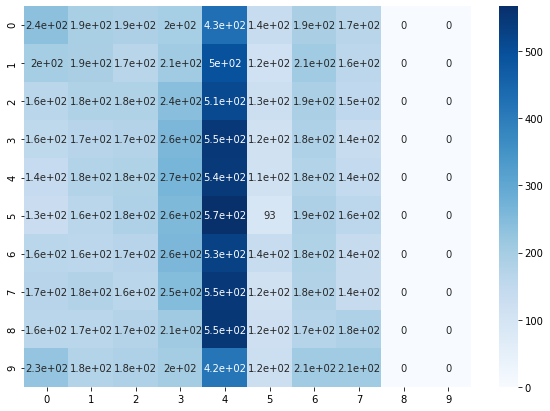

In [190]:
metrics(fm_predict,"self",y_test['new_class'])

Prediction class distribution:
             return
multi_class        
0              1758
1              1758
2              1766
3              2356
4              5142
5              1206
6              1874
7              1597
 
Confusion matrix is: (index is true value, column is prediction)
     0    1    2    3    4    5    6    7  8  9
0  239  194  187  199  428  139  192  168  0  0
1  205  197  171  216  508  118  214  164  0  0
2  164  179  179  245  520  132  193  157  0  0
3  152  173  178  257  548  112  179  134  0  0
4  140  164  173  260  526  108  169  140  0  0
5  132  169  183  249  559   94  183  157  0  0
6  169  164  174  268  544  139  189  148  0  0
7  167  176  166  252  552  119  178  139  0  0
8  169  167  173  207  544  120  170  183  0  0
9  221  175  182  203  413  125  207  207  0  0
 
label precision recall
    0     0.136  0.137
    1     0.112  0.110
    2     0.101  0.101
    3     0.109  0.148
    4     0.102  0.313
    5     0.078  0.054
    6     0

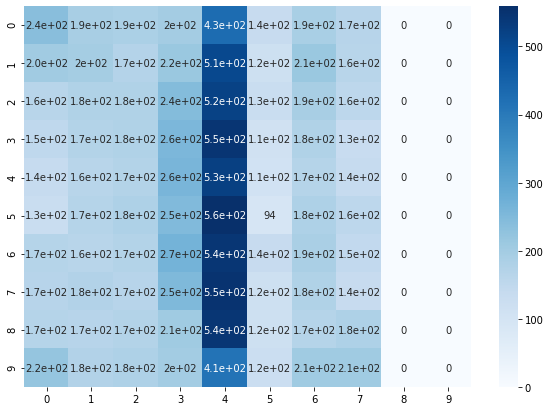

In [191]:
metrics(fm_predict,"self",y_test['multi_class'])